### You can run this notebook at Colab by clicking here:

<a target="_blank" href="https://colab.research.google.com/github/NMRLipids/databank-template/blob/museum/scripts/template.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Initialize NMRlipids databank

In [ ]:
# This installs NMRlipids Databank on COLAB environment,
# you can use the same commands on your local machine if you run it locally.

import sys
import os

os.environ["NMLDB_ROOT_PATH"] = os.path.abspath(".." + os.sep + ".." + os.sep + "Databank")

if 'google.colab' in sys.modules:
    !git clone https://github.com/NMRlipids/MuseumDatabank Databank
    %cd Databank
    !sed -i '/numpy/s/^/# /' Scripts/DatabankLib/requirements.txt
    !pip3 install .
    os.environ["NMLDB_ROOT_PATH"] = "/content/Databank"

In [2]:
import random

# These two lines include core Databank routines and Databank API
from DatabankLib.core import *
from DatabankLib.databankLibrary import *

# This initializes the databank and stores the information of all simulations into a list.
# Each list item contains the information from README.yaml file of the given simulation.
systems = initialize_databank()

Databank initialized from the folder: /big/comcon1/repo/Databank/Data/Simulations


# Select random simulation for example and show its content

In [3]:
 ### To exemplify the analysis of any simulation, we select randomly one simulation ID
randomID = None
while randomID is None:
    _rid = random.randint(1, len(systems))
    try:
        system = systems.loc(_rid)
        randomID = _rid
    except KeyError:
        pass
randomID = random.randint(1, len(systems))
#randomID=546
print('ID of the selected simulation: ', randomID)

# get system by ID
system = systems.loc(randomID)
print_README(system)

ID of the selected simulation:  615
AUTHORS_CONTACT:
  Javanainen, Matti
FF_DATE:
  None
SYSTEM:
  134CHOL_200POPC_15030SOL_310K
TYPEOFSYSTEM:
  lipid bilayer
TEMPERATURE:
  310.0
PUBLICATION:
  None
NUMBER_OF_ATOMS:
  81806
EXPERIMENT:
  {'ORDERPARAMETER': {'CHOL': {}, 'POPC': {}}, 'FORMFACTOR': {}}
FF_SOURCE:
  CHARMM-GUI (http://www.charmm-gui.org)
COMPOSITION:
  {'CHOL': {'NAME': 'CHL1', 'COUNT': [67, 67], 'MAPPING': 'mappingCHOLESTEROLcharmm.yaml'}, 'POPC': {'NAME': 'POPC', 'COUNT': [100, 100], 'MAPPING': 'mappingPOPCcharmm.yaml'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 15030, 'MAPPING': 'mappingTIP3PCHARMMgui.yaml'}}
TIMELEFTOUT:
  0
CPT:
  [['chol40_500ns.cpt']]
TRJLENGTH:
  500100.0
TRAJECTORY_SIZE:
  1521741868
SOFTWARE_VERSION:
  None
FF:
  CHARMM36
TOP:
  [['chol40.top']]
PREEQTIME:
  0
DOI:
  10.5281/zenodo.3238157
DATEOFRUNNING:
  05/10/2021
TPR:
  [['chol40.tpr']]
TRJ:
  [['chol40_500ns.xtc']]
LOG:
  None
SOFTWARE:
  gromacs
DIR_WRK:
  /media/osollila/Data/tmp/DATABANK/
ID:
  6

# Show analyzed properties stored in the NMRlipids databank for the selected system:

Membrane area per lipid: 44.821476039747196 

Membrane thickness: 4.814168060302734 

Relative equilibration time for each lipid in the simulation:
POPC: 0.12868366397777165


Plot form factor and C-H bond order parameters from the simulation together with experimental data if available 

CHOL
DOI:  10.5281/zenodo.3238157
Force field quality not found


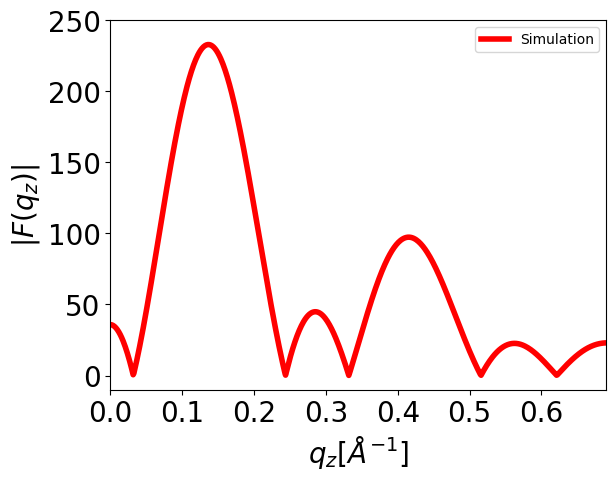

Form factor plotting failed


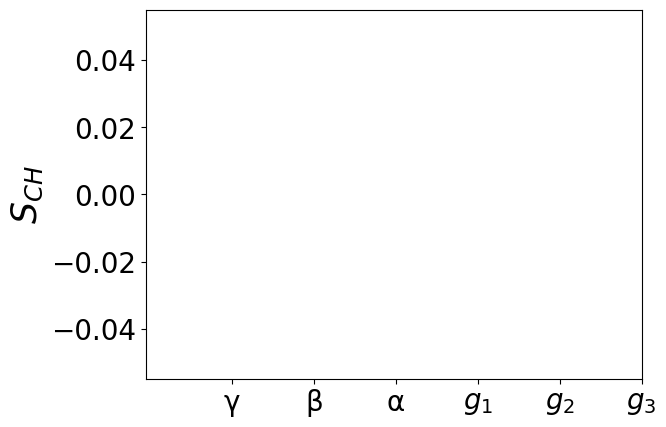

Plotting failed for  CHOL
min() arg is an empty sequence
POPC
DOI:  10.5281/zenodo.3238157
Force field quality not found


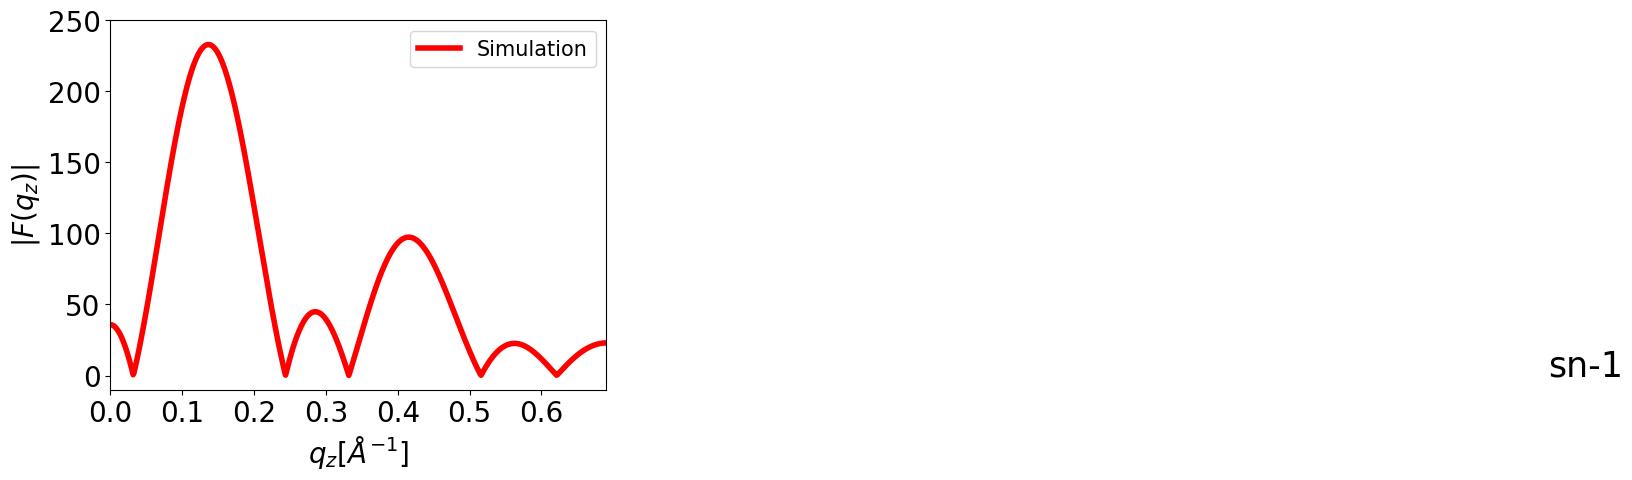

Form factor plotting failed


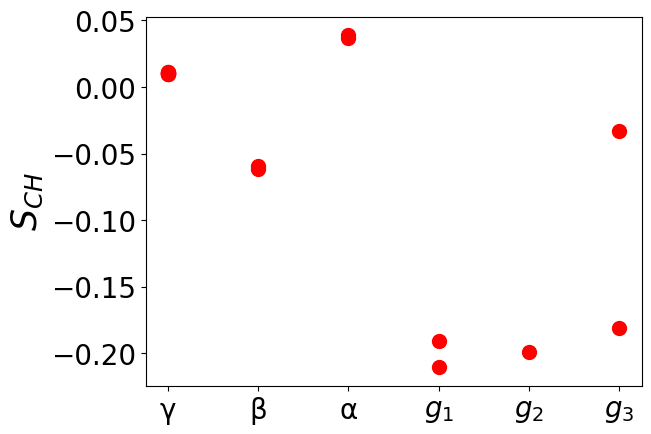

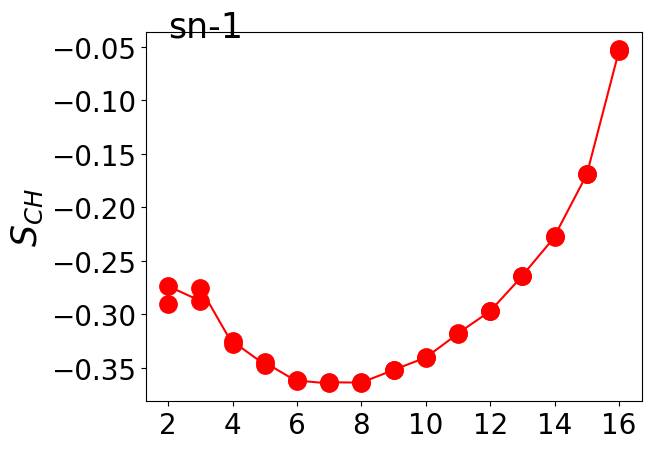

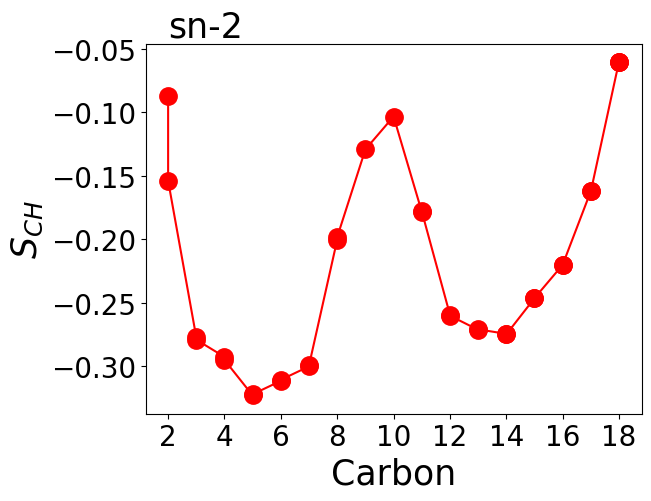

In [4]:
from DatabankLib.plottings import plotSimulation

## Membrane area per lipid, thickness, relative equilibration time, C-H bond order parameters
## and X-ray scattering form factors shown for the selected random simulation.
## We are doing all these things for a randomly picked system (loaded above).

APL = CalcAreaPerMolecule(system)
print('Membrane area per lipid:' , APL, '\n')

thickness = GetThickness(system)
print('Membrane thickness:' , thickness, '\n')

print('Relative equilibration time for each lipid in the simulation:')
ShowEquilibrationTimes(system)
print('\n')

print('Plot form factor and C-H bond order parameters from the simulation together with experimental data if available \n')
for lipid in system['COMPOSITION']:
    if lipid not in lipids_set:
        continue
    print(lipid)
    try:
        plotSimulation(system, lipid)
    except Exception as e:
        print('Plotting failed for ', lipid)
        print(e)


# Selects a random simulation with the trajectory size below 100Mb and calculates P-N vector angle with respect to membrane normal for all lipids for which P and N atoms are available in headgroup

In [5]:
systems.loc(756)

System(756): 30e/6ee/30e6eedb46c2d313b709697ae73f0671c5079dc6/7aac3f64c8467f18f5265bc5aa63ed6895c348cf/

In [ ]:
## Print simulation specific

Patom_UNI = 'M_G3P2_M'   # universal name of phophate headgroup atom
Natom_UNI = 'M_G3N6_M'   # universal name of nitrogen headgroup atom


## Finding a random simulation with smaller than 100Mb trajectory for testing
for i in range(len(systems)):
    randomID = random.randint(1, len(systems))
    try:
        system = systems.loc(randomID)
    except KeyError:
        pass
    # This filters out larger than 100Mb trajectories for testing
    if system['TRAJECTORY_SIZE'] < 100000000:
        break

print('ID number of the selected simulation: ', randomID)

# Creates MDAnalysis universe from the simulation
# This will also download simulation files if not yet available locally
MDAuni = system2MDanalysisUniverse(system)

# Loops over molecules and calculates P-N vector angle if atoms are found
for molecule in system['COMPOSITION']:
    if molecule not in lipids_set or molecule == "CHOL":
        continue
    print('\n Analysing ' + molecule)
    Patom_SIM = simulation2universal_atomnames(system,molecule,Patom_UNI)
    #print(Patom_SIM)
    Natom_SIM = simulation2universal_atomnames(system,molecule,Natom_UNI)
    #print(Natom_SIM)
    if Patom_SIM == None or Natom_SIM == None:
        continue

    #print(molecule, Patom_SIM, Natom_SIM)
    resname = system['COMPOSITION'][molecule]['NAME']
    PNangles = read_trj_PN_angles(resname, Patom_SIM, Natom_SIM, MDAuni)

    print('PN vector angle for ' + molecule + ':' + str(PNangles[2]) + ' +/- ' + str(PNangles[3]) + '\n')

ID number of the selected simulation:  27

 Analysing DPPC
PN vector angle for DPPC:72.69820046359125 +/- 0.12917165836858802

